In [1]:
import gradio

/home/bachngo/anaconda3/envs/gemm_assistant/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
import requests

# Define the paper search endpoint URL
url = 'https://api.semanticscholar.org/graph/v1/paper/search'

# Define the required query parameter and its value (in this case, the keyword we want to search for)
query_params = {
    'query': 'semantic scholar platform',
    'limit': 1
}

# Make the GET request with the URL and query parameters
search_response = requests.get(url, params=query_params)

In [44]:
# Define a separate function to make a request to the paper details endpoint using a paper_id. This function will be used later on (after we call the paper search endpoint).
def get_paper_data(paper_ids):
  url = 'https://api.semanticscholar.org/graph/v1/paper/batch'

  # Define which details about the paper you would like to receive in the response
  paper_data_query_params = {'fields': 'references'}

  # Send the API request and store the response in a variable
  response = requests.post(url, params=paper_data_query_params, json={"ids": paper_ids})
  if response.status_code == 200:
    return response.json()
  else:
    return None

# Retrieve the paper id corresponding to the 1st result in the list
paper_id = ["arxiv:2204.03458", "arxiv:2405.04133"]

# Retrieve the paper details corresponding to this paper id using the function we defined earlier.
paper_details = get_paper_data(paper_id)

In [51]:
import networkx as nx

class PaperNode:
    title: str
    arxiv_id: str
    
    def __init__(self, title, arxiv_id):
        self.title = title
        self.arxiv_id = arxiv_id

    def __str__(self) -> str:
        return f"Title: {self.title},\n Arxiv ID: {self.arxiv_id}"

class PaperEdge:
    category: str
    explanation: str
    verbose = True

    def __init__(self, category, explanation):
        self.category = category
        self.explanation = explanation

    def __str__(self) -> str:
        if self.verbose:
            return f"Category: {self.category},\n Explanation: {self.explanation}"
        else:
            return f"Category: {self.category}"

def create_ego_graph(retriever_response, service: str = "ss", graph: nx.DiGraph = None) -> nx.DiGraph:

    if service == "ss":
        paper_ids = ["arxiv:"+ n.metadata["paper_id"] for n in retriever_response]
        url = 'https://api.semanticscholar.org/graph/v1/paper/batch'

        # Define which details about the paper you would like to receive in the response
        paper_data_query_params = {'fields': 'references'}
        G = nx.DiGraph()

        # Send the API request and store the response in a variable
        response = requests.post(url, params=paper_data_query_params, json={"ids": paper_ids})
        source_nodes = []
        if response.status_code == 200:
            data = response.json()
            for idx, item in enumerate(data):
                source_node = PaperNode(
                    title=retriever_response[idx].metadata["title"],
                    arxiv_id=retriever_response[idx].metadata["paper_id"]
                )
                source_nodes.append(source_node)
                for reference in item["references"]:
                    target_node = PaperNode(
                        title=reference["title"],
                        arxiv_id=reference["paperId"]
                    )
                    
                    G.add_edge(source_node.title, target_node.title)
            
            nodes_to_remove = [node for node in G if G.degree(node) < 2]

            # Remove the nodes from the ego graph
            G.remove_nodes_from(nodes_to_remove)
            # Assign colors: highlighted nodes in red, others in blue
            highlight_color = "orange"
            for node in G.nodes():
                if node in source_nodes:
                    G.nodes[node]['color'] = highlight_color
                    
            return G
        else:
            raise ValueError(f"Request failed with status code {response.status_code}.")

[{'paperId': '4247f45a5730e3bda5836e2bc7941e30f5b91cb7', 'title': 'Board'},
 {'paperId': 'af9f365ed86614c800f082bd8eb14be76072ad16',
  'title': 'Classifier-Free Diffusion Guidance'},
 {'paperId': '4e65a4f248344c0a17e20d712d38d91085f608a2',
  'title': 'Transframer: Arbitrary Frame Prediction with Generative Models'},
 {'paperId': '1641774b55a471a23eb31b722ee05c2e032fec7a',
  'title': 'Diffusion Probabilistic Modeling for Video Generation'},
 {'paperId': '7002ae048e4b8c9133a55428441e8066070995cb',
  'title': 'GLIDE: Towards Photorealistic Image Generation and Editing with Text-Guided Diffusion Models'},
 {'paperId': '9eeb5f7c36654dff1dc93adb7150e7bab52cd3e2',
  'title': 'Deblurring via Stochastic Refinement'},
 {'paperId': '97bee918b08c244eb2e54d41e8ea6da00a3e5dbf',
  'title': 'NÜWA: Visual Synthesis Pre-training for Neural visUal World creAtion'},
 {'paperId': '37c9c4e7648f639c0b36f150fc6c6c90b3682f4a',
  'title': 'Palette: Image-to-Image Diffusion Models'},
 {'paperId': '5e51ebd5507cf6

In [16]:
import requests
import feedparser

def get_latest_arxiv_papers(categories=['cs.AI', 'cs.CV', 'cs.IR', 'cs.LG', 'cs.CL'], max_results=50):
    base_url = 'http://export.arxiv.org/api/query?'
    all_categories=[f'cat:{category}' for category in categories]
    search_query = '+OR+'.join(all_categories)
    query = f'search_query={search_query}&start=0&max_results={max_results}&sortBy=submittedDate&sortOrder=descending'
    response = requests.get(base_url + query)
    feed = feedparser.parse(response.content)
    return feed.entries

response = get_latest_arxiv_papers()

In [17]:
response[0]

{'id': 'http://arxiv.org/abs/2405.08816v1',
 'guidislink': True,
 'link': 'http://arxiv.org/abs/2405.08816v1',
 'updated': '2024-05-14T17:59:57Z',
 'updated_parsed': time.struct_time(tm_year=2024, tm_mon=5, tm_mday=14, tm_hour=17, tm_min=59, tm_sec=57, tm_wday=1, tm_yday=135, tm_isdst=0),
 'published': '2024-05-14T17:59:57Z',
 'published_parsed': time.struct_time(tm_year=2024, tm_mon=5, tm_mday=14, tm_hour=17, tm_min=59, tm_sec=57, tm_wday=1, tm_yday=135, tm_isdst=0),
 'title': 'The RoboDrive Challenge: Drive Anytime Anywhere in Any Condition',
 'title_detail': {'type': 'text/plain',
  'language': None,
  'base': '',
  'value': 'The RoboDrive Challenge: Drive Anytime Anywhere in Any Condition'},
 'summary': "In the realm of autonomous driving, robust perception under\nout-of-distribution conditions is paramount for the safe deployment of\nvehicles. Challenges such as adverse weather, sensor malfunctions, and\nenvironmental unpredictability can severely impact the performance of\nautono

In [27]:
template = """
I am interested in LLM, Generative AI and trendy stuffs in AI, picks out the most notable papers published today:

==============
{paper_list}

"""

paper_list = []

for r in response:
    paper_list.append(f"""
Title: {r['title']}
Link: {r['link']}
Summary: {r['summary']}
                  
    """)

prompt = prompt = template.format(paper_list="\n==============\n".join(paper_list))

In [31]:
from llama_index.llms.openai import OpenAI
import os
import dotenv
dotenv.load_dotenv(override=True)

llm = OpenAI(model="gpt-4o", api_key=os.environ["OPENAI_API_KEY"])
res = llm.complete(prompt)

In [33]:
print(res)

Here are some of the most notable papers published today in the fields of Large Language Models (LLMs), Generative AI, and other trendy AI topics:

1. **MambaOut: Do We Really Need Mamba for Vision?**
   - **Link:** [arxiv.org/abs/2405.07992v1](http://arxiv.org/abs/2405.07992v1)
   - **Summary:** This paper explores the necessity of the Mamba architecture for vision tasks, concluding that Mamba is not essential for image classification but shows potential for long-sequence visual tasks like detection and segmentation.

2. **SPIN: Simultaneous Perception, Interaction and Navigation**
   - **Link:** [arxiv.org/abs/2405.07991v1](http://arxiv.org/abs/2405.07991v1)
   - **Summary:** Introduces a reactive mobile manipulation framework that integrates perception, interaction, and navigation, allowing a mobile manipulator to navigate and interact with its environment using an active visual system.

3. **Plot2Code: A Comprehensive Benchmark for Evaluating Multi-modal Large Language Models in Co

In [1]:
import requests
import feedparser
from datetime import datetime, timedelta
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
import time
from wordcloud import WordCloud


# Step 1: Fetch and Parse Papers
def fetch_arxiv_papers():
    max_results = 100
    categories = ['cs.AI', 'cs.CV', 'cs.IR', 'cs.LG', 'cs.CL']
    base_url = 'http://export.arxiv.org/api/query?'
    all_categories = [f'cat:{category}' for category in categories]
    search_query = '+OR+'.join(all_categories)
    
    paper_list = []
    start = 0
    today = datetime.utcnow().date()
    one_week_ago = today - timedelta(days=7)
    wait_time = 3
    new_papers_found = True

    while new_papers_found:
        query = f'search_query={search_query}&start={start}&max_results={max_results}&sortBy=submittedDate&sortOrder=descending'
        response = requests.get(base_url + query)
        feed = feedparser.parse(response.content)
        
        for r in feed.entries:
            paper_date = datetime.strptime(r['published'][:10], '%Y-%m-%d').date()
            print(paper_date)

            if one_week_ago <= paper_date:
                new_papers_found = True
                paper_list.append({
                    "title": r['title'],
                    "summary": r['summary'],
                    "categories": [tag['term'] for tag in r.tags],
                    "date": paper_date
                })
            else:
                # Stop fetching if the paper date is older than one week
                new_papers_found = False
                break
        
        start += max_results
        time.sleep(wait_time)
    
    return paper_list

# Step 2: Extract Keywords
def extract_keywords(papers):
    vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    texts = [paper['title'] + '\n' + paper['summary'] for paper in papers]
    X = vectorizer.fit_transform(texts)
    keywords = vectorizer.get_feature_names_out()
    return keywords, X

# Step 3: Count Keyword Frequency
def count_keyword_frequency(X, keywords):
    keyword_counts = X.sum(axis=0).A1
    keyword_freq = dict(zip(keywords, keyword_counts))
    return keyword_freq

# Step 4: Create Keyword Co-occurrence Matrix
def create_cooccurrence_matrix(X, keywords):
    cooccurrence_matrix = (X.T @ X).toarray()
    return cooccurrence_matrix

# Step 5: Visualize the Keyword Graph using PyVis
def visualize_keyword_graph(cooccurrence_matrix, keywords, keyword_freq, top_n=20, threshold=5):
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_freq)
    
    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Keyword Word Cloud')
    plt.show()

In [24]:
from llama_index.core import Document
import requests
from datetime import datetime, timedelta
import time

def get_daily_arxiv_papers():
    max_results = 25
    categories = ['cs.AI', 'cs.CV', 'cs.IR', 'cs.LG', 'cs.CL']
    base_url = 'http://export.arxiv.org/api/query?'
    all_categories = [f'cat:{category}' for category in categories]
    search_query = '+OR+'.join(all_categories)
    
    paper_list = []
    start = 0
    today = datetime.utcnow().date()
    new_papers_found = True
    wait_time = 3

    while new_papers_found:
        query = f'search_query={search_query}&start={start}&max_results={max_results}&sortBy=submittedDate&sortOrder=descending'
        response = requests.get(base_url + query)
        feed = feedparser.parse(response.content)
        
        for r in feed.entries:
            paper_date = datetime.strptime(r['published'][:10], '%Y-%m-%d').date()
            if paper_date >= today - timedelta(1):
                new_papers_found = True
                paper_list.append(Document(text=f"""
Title: {r['title']}
{r['summary']}
                """, metadata={'paper_id': r['id'].split("/")[-1], 'title': r['title'], 'date': r['published'][:10]}))
            else:
                new_papers_found = False
                break
        
        start += max_results
        time.sleep(wait_time)

    return paper_list


In [25]:
papers = get_daily_arxiv_papers()
print(len(papers))

153


In [3]:
papers

[{'title': 'MambaOut: Do We Really Need Mamba for Vision?',
  'summary': "Mamba, an architecture with RNN-like token mixer of state space model (SSM),\nwas recently introduced to address the quadratic complexity of the attention\nmechanism and subsequently applied to vision tasks. Nevertheless, the\nperformance of Mamba for vision is often underwhelming when compared with\nconvolutional and attention-based models. In this paper, we delve into the\nessence of Mamba, and conceptually conclude that Mamba is ideally suited for\ntasks with long-sequence and autoregressive characteristics. For vision tasks,\nas image classification does not align with either characteristic, we\nhypothesize that Mamba is not necessary for this task; Detection and\nsegmentation tasks are also not autoregressive, yet they adhere to the\nlong-sequence characteristic, so we believe it is still worthwhile to explore\nMamba's potential for these tasks. To empirically verify our hypotheses, we\nconstruct a series of

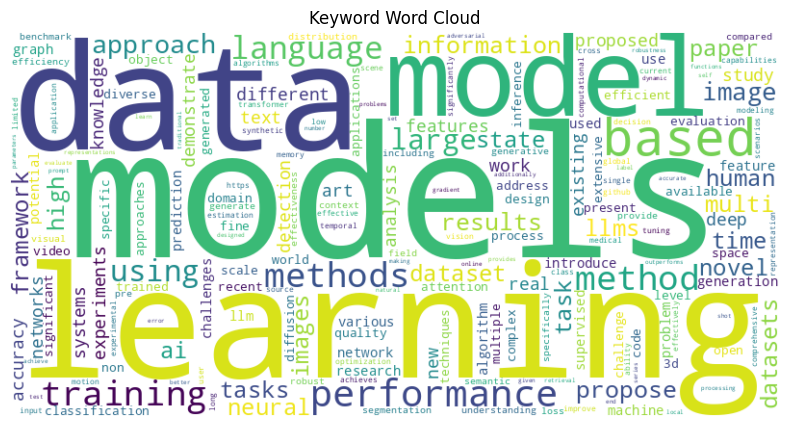

In [4]:
keywords, X = extract_keywords(papers)
keyword_freq = count_keyword_frequency(X, keywords)
cooccurrence_matrix = create_cooccurrence_matrix(X, keywords)
visualize_keyword_graph(cooccurrence_matrix, keywords, keyword_freq)

# Paper Trend Analysis

In [5]:
abstracts = [paper['title'] + "\n" + paper['summary'] for paper in papers]

In [47]:
with open("abstracts.txt", "w") as f:
    f.write("\n==========\n".join(abstracts))

In [24]:
# Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model
from langchain.chat_models import ChatOpenAI

# Embedding Support
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans

In [26]:
docs = [Document(page_content=abstract) for abstract in abstracts]

In [36]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)
embeddings = OpenAIEmbeddings(openai_api_key=os.environ.get("OPENAI_API_KEY"))

vectors = embeddings.embed_documents([x.page_content for x in docs])

In [39]:
# Assuming 'embeddings' is a list or array of 1536-dimensional embeddings

# Choose the number of clusters, this can be adjusted based on the book's content.
# I played around and found ~10 was the best.
# Usually if you have 10 passages from a book you can tell what it's about
num_clusters = 11

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

In [40]:
kmeans.labels_

array([ 5,  3,  1,  9,  3,  8,  4,  3,  0,  5,  5,  6,  9, 10, 10,  1,  2,
        3,  1,  9, 10,  1,  1,  7,  7,  6, 10,  8,  3,  0,  9,  6,  1,  2,
        1,  8,  5,  5,  4,  8,  7,  8,  7,  5,  7,  2,  1, 10,  6,  0,  3,
        2,  6,  9,  2,  8,  5,  0,  0,  3,  2,  1,  6,  6,  0,  4,  1,  9,
        2,  6,  1,  7, 10,  3,  4,  2,  1,  3,  1,  1,  8,  1,  6,  7,  2,
        0,  4,  1,  2,  2,  3,  5,  5,  2,  1,  9,  1,  5,  7,  3,  2,  6,
        6,  8,  5,  1,  0,  9,  3,  1,  3,  0,  0,  8,  4,  8,  6,  2,  1,
        5,  2,  6,  1,  6, 10,  7,  2,  5, 10,  5,  7,  3,  1,  1,  5,  5,
        2,  9,  8,  6,  1,  0, 10,  6,  6,  4,  2,  1,  9,  7,  0,  0,  2,
       10,  7,  4,  2,  5,  7,  7, 10,  9,  1,  8,  9, 10,  2,  1,  1,  5,
        0,  2,  1,  2,  1,  1,  6,  0,  4,  2,  9,  1,  2,  4,  0,  1,  5,
        7,  5,  0,  7, 10,  4,  1,  3,  5,  2,  7,  2,  7, 10,  2,  5,  1,
        1,  0, 10,  5,  1,  7,  9, 10,  5,  5,  0, 10,  2,  3,  5,  1,  5,
        4,  8,  5,  3,  0

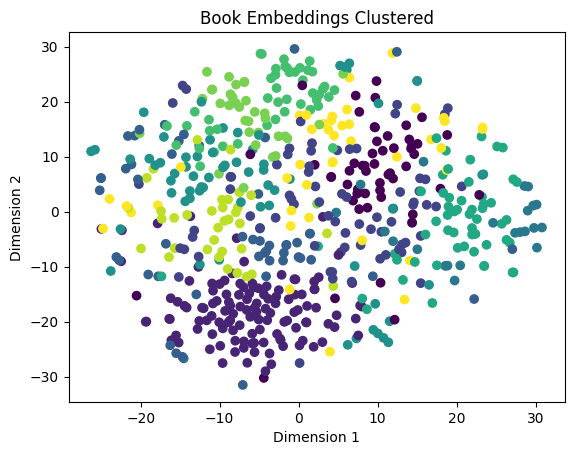

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

In [42]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):
    
    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)
    
    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)
    
    # Append that position to your closest indices list
    closest_indices.append(closest_index)

In [43]:
selected_indices = sorted(closest_indices)
selected_indices

[25, 28, 72, 252, 446, 466, 467, 533, 549, 582, 591]

In [44]:
llm3 = ChatOpenAI(temperature=0,
                 openai_api_key=os.environ.get("OPENAI_API_KEY"),
                 max_tokens=1000,
                 model='gpt-3.5-turbo'
                )

/home/gb2t/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [12]:
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.embeddings.openai import OpenAIEmbedding
from dotenv import load_dotenv
import os
load_dotenv("../.env",override=True)

Settings.llm = OpenAI(temperature=0.2, model="gpt-4o", api_key=os.environ["OPENAI_API_KEY"])
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small", api_key=os.environ["OPENAI_API_KEY"])

documents = SimpleDirectoryReader("../data/FPT_Docs/").load_data()
index = VectorStoreIndex.from_documents(
    documents,
    
)
query_engine = index.as_query_engine()

In [15]:
query_engine.query("Chương trình nâng cấp wifi 5 lên wifi 6 áp dụng nhu the nao? toi la khach hang nang cao")

Response(response='Chương trình nâng cấp wifi 5 lên wifi 6 cho khách hàng dùng gói nâng cao được áp dụng như sau:\n\n1. Gói nâng cao wifi 5 nâng cấp lên wifi 6:\n   - Gói wifi 5: SuperS80, S100 (nhỏ hơn 150M) -> Gói wifi 6: Giga\n   - Gói wifi 5: Giga -> Gói wifi 6: Sky\n   - Gói wifi 5: Sky -> Gói wifi 6: Meta\n   - Gói wifi 5: Meta -> Gói wifi 6: Meta\n\n2. Phí chuyển đổi: 110.000 VNĐ\n\n3. Tiền cước dịch vụ sau nâng cấp không thay đổi\n\n4. Thiết bị trang bị kèm: 1 modem wifi 6, hoặc 1 ONU + 1 AP wifi 6', source_nodes=[NodeWithScore(node=TextNode(id_='815c0f74-7248-4eab-8164-ed7c23741455', embedding=None, metadata={'file_name': 'Dạy-bot-Chính-sách-wifi-6.docx', 'file_path': '/media/gb2t/Data/GemmaResearchAssistant/notebooks/../data/FPT_Docs/Dạy-bot-Chính-sách-wifi-6.docx', 'file_type': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document', 'file_size': 23959, 'creation_date': '2024-05-15', 'last_modified_date': '2024-05-15'}, excluded_embed_metadata_keys=['file_n